In [31]:
import numpy as np
import sys
from astropy.io import ascii

import astropy.units as u
from astropy.nddata import StdDevUncertainty

sys.path.append('..')
from astrodb_utils.fits import add_missing_keywords, add_observation_date, add_wavelength_keywords, check_header

from astropy.io.fits import getheader
from specutils import Spectrum
from astrodb_utils.spectra import check_spectrum_plottable

In [33]:
from specutils import Spectrum
from specutils.manipulation import snr_threshold
import matplotlib.pyplot as plt

from astropy.time import Time

In [145]:
fits_created = 0

In [37]:
link = './xshyne_data.csv'
xshyne_table = ascii.read(
    link,
    format="csv",
    data_start=1,
    header_start=0,
    guess=False,
    fast_reader=False, 
    delimiter=",",
)

In [97]:
def load_file(source):
    path = f'./xshyne_npz/{source}.npz'
    file_open = np.load(path)
    
    wave = file_open['wl']
    flux = file_open['flx']
    err = file_open['err']

    return wave, flux, err


In [113]:
def add_wavelength():#wavelength from XSHYNE data is in micrometers...
    #convert to Angstrom: 1 micron = 10000 AA
    wave_min = np.round(wave.min() * 10000,2)
    wave_max = np.round(wave.max() * 10000,2)
    wavelength = np.arange(wave_min, wave_max)*u.AA
    add_wavelength_keywords(header, wavelength)

    header.set('SPECBAND', 'em.IR.J, em.IR.H, em.IR.K, em.opt.R, em.opt.I')
    header  #  Notice the new keywords and values added to the header

In [109]:
def add_TMID(start_date, end_date):
    start = Time(start_date, format = "iso")
    end = Time(end_date, format = "iso")

    result = (start.mjd + end.mjd)/2
    print(f"TMID mjd:{result}")
    header.set('TMID', result)

In [57]:
def add_keywords(
    source:str = None,
    ra:float = None,
    dec:float = None,
    instrum:str = "VLT/X-Shooter",
    tele:str = "ESO VLT",
    observ:str = "La Silla Paranal",
    vOPub:str = "SIMPLE-Archive",
    vORef:str = "https://www.aanda.org/articles/aa/full_html/2023/02/aa44494-22/aa44494-22.html",
    title:str = "X-SHYNE: X-shooter spectra of young exoplanet analogs",
    author:str = "Petrus et al.",
    contrib1:str = "Leslie Han",
    tmid:str = None,
    telapse:str = None,
    aperture:str = None
):
    header.set('OBJECT', source)
    header.set('RA_TARG', ra)
    header.set('DEC_TARG', dec)
    header.set('INSTRUME', instrum)
    header.set('TELESCOP', tele)
    header.set('OBSERVAT', observ)
    header.set('VOPUB', vOPub)
    header.set('VOREF', vORef)
    header.set('TITLE', title)
    header.set('AUTHOR', author)
    header.set('CONTRIB1', contrib1)
    header.set('TMID', tmid)
    header.set('TELAPSE', telapse)
    header.set('APERTURE', aperture)

In [59]:
def create_fits_file(wave, flux, err, header, source):
    # Create the Spectrum object
    converted_spectrum = Spectrum(
        spectral_axis=wave * u.um,
        flux=flux * u.Jy,
        uncertainty=StdDevUncertainty(err * u.Jy)
    )
    converted_spectrum.meta["header"] = header
    
    # Write the Spectrum object to a FITS file
    converted_spectrum.write(f'{source}_Petr25.fits', format="tabular-fits")
    
    # Check that the spectrum is readable and plottable
    # If you have matplotlib installed, use show_plot = True to display the spectrum
    check_spectrum_plottable(f'{source}_Petr25.fits', show_plot=True, format = "tabular-fits")

In [157]:
def mask_plots(wave, flux):
    #figure out how to mask the plot...

COPY AND PASTE THE FOLLOWING COMMANDS INTO YOUR SCRIPT 
Replace <value> with the appropriate value for your dataset 
If you're not sure of the correct value, use None 
If you started with a header object not called `header`, 
replace 'header' with the name of your header object 
Use the `astrodb_utils.fits.add_wavelength_keywords` function 
to add the SPEC_VAL, SPEC_BW, TDMID1, TDMAX1, and SPECBAND keywords 

header.set('OBJECT', "<value>")
header.set('RA_TARG', "<value>")
header.set('DEC_TARG', "<value>")
header.set('INSTRUME', "<value>")
header.set('TELESCOP', "<value>")
header.set('OBSERVAT', "<value>")
header.set('VOCLASS', "<value>")
header.set('VOPUB', "<value>")
header.set('VOREF', "<value>")
header.set('TITLE', "<value>")
header.set('AUTHOR', "<value>")
header.set('CONTRIB1', "<value>")
header.set('DATE-OBS', "<value>")
header.set('TMID', "<value>")
header.set('TELAPSE', "<value>")
header.set('SPEC_VAL', "<value>")
header.set('SPEC_BW', "<value>")
header.set('TDMIN1', "<value>"

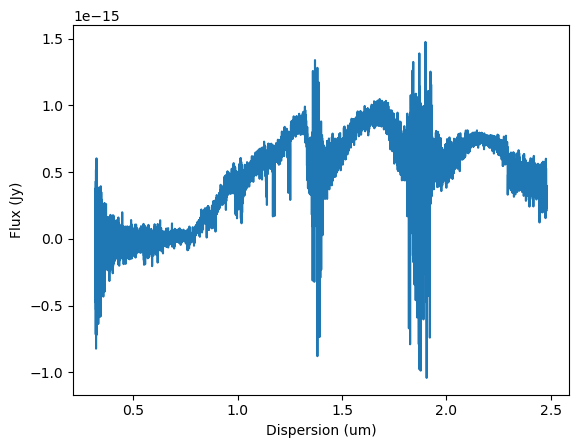

TypeError: masked_where() missing 1 required positional argument: 'a'

In [159]:
for row in xshyne_table:
    #create new header
    header = add_missing_keywords()

    source = row['Source']
    short_name = row['Short Name']
    date = row['Date']
    ra = row['Ra']
    dec = row['Dec']
    start_date = row['Start Date']
    end_date = row['End Date']
    
    #read the file
    load = load_file(short_name)
    wave = load[0]
    flux = load[1]
    err = load[2]
    print(wave, flux, err)

    add_wavelength()
    add_TMID(start_date, end_date)
    add_observation_date(header, date)

    add_keywords(source = source, ra = ra, dec = dec, observ = date)

    if short_name == '2MASS0030': 
        check_header(header=header, ignore_simbad = True)
    else:
        check_header(header)

    create_fits_file(wave = wave, flux = flux, err = err, header = header, source = short_name)
    fits_created+=1

    mask_plots(wave=wave,flux=flux)

In [117]:
print(f"Fits file created: {fits_created}")

Fits file created: 43
